<a href="https://colab.research.google.com/github/thanhtrinh2003/GarbageClassificationKaggle/blob/main/Method_2_Kaggle_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def list_dataset():
    for dirname, _, filenames in os.walk('/content/drive/MyDrive/Lumiere 2021/Code/Garbage classification/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

            
# Add class name prefix to each path based on class name include in filename
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df


def class_id_to_label(id):
    label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}
    return label_map[id]

IMAGES_DIR = '/content/drive/MyDrive/Lumiere 2021/Code/Garbage classification/'
    
train_file = '/content/drive/MyDrive/Lumiere 2021/Code/Info/one-indexed-files-notrash_train.txt'
val_file   = '/content/drive/MyDrive/Lumiere 2021/Code/Info/one-indexed-files-notrash_val.txt'
test_file  = '/content/drive/MyDrive/Lumiere 2021/Code/Info/one-indexed-files-notrash_test.txt'

df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])

df_train = add_class_name_prefix(df_train, 'rel_path')
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_test  = add_class_name_prefix(df_test,  'rel_path')

df_train['label'] = df_train['label'].apply(class_id_to_label)
df_valid['label'] = df_valid['label'].apply(class_id_to_label)
df_test['label']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')


Found 1768 training, 328 validation and 328 samples.


In [ ]:
df_train.head()

,rel_path,label
0,cardboard/cardboard202.jpg,cardboard
1,paper/paper472.jpg,paper
2,paper/paper522.jpg,paper
3,glass/glass189.jpg,glass
4,glass/glass325.jpg,glass


In [ ]:
datagen = ImageDataGenerator()

datagen_train = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

datagen_valid = datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=7,
)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


In [ ]:
def build_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False
        
    return model


net = build_model(num_classes=6)

net.compile(optimizer='Adam',
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.categorical_accuracy])

net.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
count = 0;
for x in net.layers:
  if x.trainable == False:
    count = count +1

print(count)

175


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = net.fit_generator(
    generator=datagen_train,
    validation_data=datagen_valid,
    epochs=30,
    validation_freq=1,
    callbacks=[early_stop]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
56/56 [==============================] - 1231s 22s/step - loss: 1.0404 - categorical_accuracy: 0.6900 - val_loss: 0.4487 - val_categorical_accuracy: 0.8323
Epoch 2/30
56/56 [==============================] - 10s 171ms/step - loss: 0.3279 - categorical_accuracy: 0.8891 - val_loss: 0.3329 - val_categorical_accuracy: 0.8720
Epoch 3/30
56/56 [==============================] - 10s 171ms/step - loss: 0.1965 - categorical_accuracy: 0.9367 - val_loss: 0.4029 - val_categorical_accuracy: 0.8598
Epoch 4/30
56/56 [==============================] - 10s 173ms/step - loss: 0.1635 - categorical_accuracy: 0.9457 - val_loss: 0.4018 - val_categorical_accuracy: 0.8537
Epoch 5/30
56/56 [==============================] - 10s 169ms/step - loss: 0.0953 - categorical_accuracy: 0.9712 - val_loss: 0.4033 - val_categorical_accuracy: 0.8537
Epoch 6/30
56/56 [==============================] - 10s 170ms/step - loss: 0.0642 - categorical_accuracy: 0.9768 - val_loss: 0.2641 - val_categorical_accuracy: 0.902

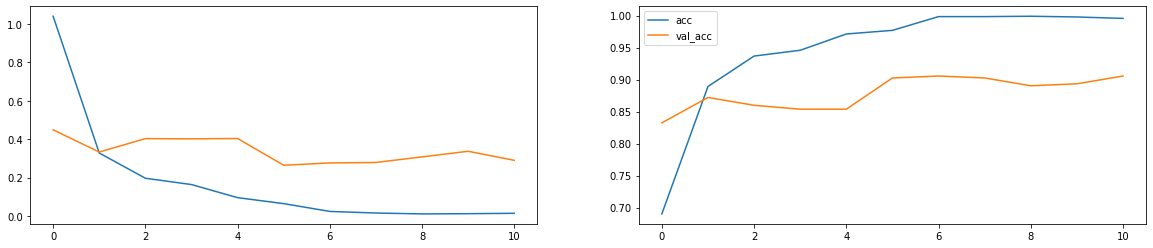

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')

axs[1].plot(history.history['categorical_accuracy'], label='acc')
axs[1].plot(history.history['val_categorical_accuracy'], label='val_acc')

plt.legend();
plt.show();

In [ ]:
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGES_DIR,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=7
)

# y_pred = net.predict(test_generator, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

filenames = test_generator.filenames
nb_samples = len(filenames)

preds = net.predict_generator(test_generator, nb_samples, workers=1)
net.evaluate_generator(test_generator, nb_samples)

Found 328 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.2640801966190338, 0.9024389982223511]

In [ ]:
Y_test = df_test.copy()
Y_test= Y_test.loc[:, 'label'].values
print(Y_test)










['cardboard' 'plastic' 'glass' 'glass' 'glass' 'cardboard' 'metal' 'trash'
 'glass' 'paper' 'cardboard' 'metal' 'paper' 'paper' 'glass' 'glass'
 'glass' 'paper' 'trash' 'plastic' 'cardboard' 'plastic' 'paper' 'glass'
 'plastic' 'glass' 'plastic' 'plastic' 'metal' 'paper' 'paper' 'glass'
 'paper' 'cardboard' 'paper' 'glass' 'plastic' 'plastic' 'metal' 'metal'
 'metal' 'plastic' 'paper' 'cardboard' 'glass' 'metal' 'metal' 'cardboard'
 'glass' 'trash' 'paper' 'paper' 'paper' 'cardboard' 'cardboard' 'plastic'
 'glass' 'plastic' 'cardboard' 'metal' 'metal' 'glass' 'metal' 'glass'
 'trash' 'glass' 'cardboard' 'glass' 'cardboard' 'paper' 'plastic'
 'cardboard' 'trash' 'metal' 'paper' 'paper' 'paper' 'paper' 'glass'
 'paper' 'metal' 'glass' 'cardboard' 'plastic' 'metal' 'cardboard' 'glass'
 'plastic' 'paper' 'glass' 'paper' 'glass' 'paper' 'plastic' 'cardboard'
 'metal' 'paper' 'glass' 'plastic' 'paper' 'paper' 'cardboard' 'glass'
 'cardboard' 'plastic' 'plastic' 'glass' 'metal' 'plastic' 'car

In [ ]:
class_dictionary = test_generator.class_indices
print(class_dictionary)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [ ]:
id_class = {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

for id, val in enumerate(Y_test):
  Y_test[id] = id_class[val]

In [ ]:
Y_preds = list(np.array(np.argmax(preds, axis=1)))
Y_test = list(Y_test)



In [ ]:
from sklearn.metrics import confusion_matrix 
cmat = confusion_matrix(Y_test, Y_preds) 
cmat 

array([[43,  0,  1,  0,  2,  0],
       [ 0, 56,  4,  0,  5,  0],
       [ 0,  2, 52,  0,  2,  0],
       [ 0,  0,  1, 79,  2,  1],
       [ 0,  4,  2,  2, 53,  0],
       [ 0,  0,  1,  2,  1, 13]])

In [ ]:
print("Top 1 cardboard: " + str(cmat[0][0]/np.sum(cmat[0])))
print("Top 1 glass: " + str(cmat[1][1]/np.sum(cmat[1])))
print("Top 1 metal: " + str(cmat[2][2]/np.sum(cmat[2])))
print("Top 1 paper: " + str(cmat[3][3]/np.sum(cmat[3])))
print("Top 1 plastic: " + str(cmat[4][4]/np.sum(cmat[4])))
print("Top 1 trash: " + str(cmat[5][5]/np.sum(cmat[5])))

Top 1 cardboard: 0.9347826086956522
Top 1 glass: 0.8615384615384616
Top 1 metal: 0.9285714285714286
Top 1 paper: 0.9518072289156626
Top 1 plastic: 0.8688524590163934
Top 1 trash: 0.7647058823529411


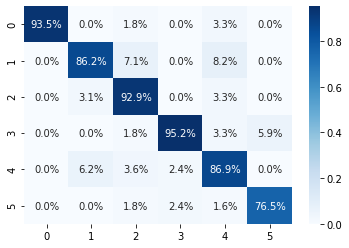

In [ ]:
import seaborn as sns
sns.heatmap(cmat/np.sum(cmat, axis=1), annot=True, fmt='.01%', cmap='Blues')